In [19]:
import torch
import numpy as np
import matplotlib.pyplot as plt

torch.random.manual_seed(1337)
np.random.seed(1337)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using:", device)

from lib.plotutility import set_eda_style
set_eda_style()

Using: cpu


In [20]:
from lib.mitmproxyloader import load_mitm_packets_as_dataframe
from lib.mitmdataset import MitmProxyLogsDataset
from lib.mitmpairdataset import create_pairs_from_mitm_arrays, MitmProxyPairDataset

packet_dataframe = load_mitm_packets_as_dataframe("./data/")

def preprocess_dataframe(packet_dataframe):
    import json

    # Get filenames with entries < 1000
    filenames = packet_dataframe['filename'].value_counts()
    filenames = filenames[filenames < 1000]

    # Remove filenames with entries < 4000
    packet_dataframe = packet_dataframe[~packet_dataframe['filename'].isin(filenames.index)]

    # Filter out all rows, where 'name' is not in 'body'
    packet_dataframe = packet_dataframe[packet_dataframe['body'].str.contains('name')]

    new_df = packet_dataframe.copy()

    for i, row in packet_dataframe.iterrows():
        body = row['body']
        if 'applyOtUpdate' in body:
            json_str = body.split('::')[1]
            json_obj = json.loads(json_str)
            content = json_obj['args'][1]['op'][0]

            content_keys = content.keys()

            if 'i' in content_keys:
                new_df.at[i, 'bytes'] = len(content['i'])
            else:
                new_df.at[i, 'bytes'] = -len(content['d'])

            new_df.at[i, 'body'] = content
        else:
            new_df.at[i, 'body'] = "ACK"
            new_df.at[i, 'bytes'] = 0

    return new_df

packet_dataframe = preprocess_dataframe(packet_dataframe)
# Drop all entries with 'ACK' in body
print("Previous length:", len(packet_dataframe))
packet_dataframe = packet_dataframe[packet_dataframe['body'] != 'ACK']
print("New length:", len(packet_dataframe))

Previous length: 198987
New length: 99456


In [36]:
print("Num labels:", len(packet_dataframe["filename"].unique()))

total_dataset = MitmProxyLogsDataset(packet_dataframe, training=True, chunk_size=64, scale_zero_to_one=True, apply_highpass=False, subtract_mean=False, scale_negative_separately=True)

def perform_k_split(k, dataset):
    from sklearn.model_selection import KFold

    kf = KFold(n_splits=k, shuffle=True)

    for train_index, test_index in kf.split(dataset):
        train_dataset = dataset[train_index]
        test_dataset = dataset[test_index]

        training_pairs, training_labels = create_pairs_from_mitm_arrays(train_dataset[0], train_dataset[1])
        testing_pairs, testing_labels = create_pairs_from_mitm_arrays(test_dataset[0], test_dataset[1])

        training_pair_dataset = MitmProxyPairDataset(training_pairs, training_labels)
        testing_pair_dataset = MitmProxyPairDataset(testing_pairs, testing_labels)

        yield {
            "train": training_pair_dataset,
            "test": testing_pair_dataset
        }

dataset_splits = list(perform_k_split(5, total_dataset))

Num labels: 75
Dataset Statistics
-------------------------------------------------------
Max value diff:   62930889000
Max value bytes:  29
Mean value diff:  2848719540
Mean value bytes: 3.7033361486486487
Std value diff:   4100478547
Std value bytes:  2.6873403451125877
Chunks per group: 4
-------------------------------------------------------


In [37]:
def extract_features_from_pair(pair):
    features = np.zeros((32))

    pair = pair.numpy()

    for i in range(4):
        features[i * 4 + 0] = np.mean(pair[0][i])
        features[i * 4 + 1] = np.std(pair[0][i])
        features[i * 4 + 2] = np.max(pair[0][i])
        features[i * 4 + 3] = np.min(pair[0][i])

    for i in range(4):
        features[i * 4 + 16] = np.mean(pair[1][i])
        features[i * 4 + 17] = np.std(pair[1][i])
        features[i * 4 + 18] = np.max(pair[1][i])
        features[i * 4 + 19] = np.min(pair[1][i])

    return features

def dataset_to_classifier_input(dataset: MitmProxyPairDataset):
    X_raw = dataset.pairs
    y = dataset.labels

    y = np.array(y)

    X = np.zeros((len(X_raw), 32))

    for i in range(len(X_raw)):
        features = extract_features_from_pair(X_raw[i])
        X[i] = features

    return X, y

In [38]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score

accuracies = []
precisions = []
recalls = []
f1_scores = []

y_preds = []
y_trues = []

tree_param = {'criterion':['gini'],'max_depth':[2, 5, 10, 20]}

for i, dataset_split in enumerate(dataset_splits):
    print("Fold", i)

    training_X, training_y = dataset_to_classifier_input(dataset_split["train"])
    testing_X, testing_y = dataset_to_classifier_input(dataset_split["test"])

    clf = GridSearchCV(DecisionTreeClassifier(), tree_param, cv=5, n_jobs=-1)
    clf.fit(training_X, training_y)

    accuracy = clf.score(testing_X, testing_y)
    accuracies.append(accuracy)

    precision = precision_score(testing_y, clf.predict(testing_X))
    precisions.append(precision)

    recall = recall_score(testing_y, clf.predict(testing_X))
    recalls.append(recall)

    f1 = f1_score(testing_y, clf.predict(testing_X))
    f1_scores.append(f1)

    y_preds.append(clf.predict(testing_X))
    y_trues.append(testing_y)

Fold 0
Fold 1
Fold 2


C:\Users\alexa\AppData\Local\Temp\ipykernel_30296\1001724676.py:24: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y = np.array(y)
C:\Users\alexa\AppData\Local\Temp\ipykernel_30296\1001724676.py:24: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y = np.array(y)
C:\Users\alexa\AppData\Local\Temp\ipykernel_30296\1001724676.py:24: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' 

Fold 3
Fold 4


C:\Users\alexa\AppData\Local\Temp\ipykernel_30296\1001724676.py:24: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y = np.array(y)
C:\Users\alexa\AppData\Local\Temp\ipykernel_30296\1001724676.py:24: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y = np.array(y)


In [39]:
def perc_print(percentage):
    return f"{percentage * 100:.2f}\\%"

print(f"{perc_print(np.mean(accuracies))} $\\pm$ {perc_print(np.std(accuracies))}")
print(f"{perc_print(np.mean(precisions))} $\\pm$ {perc_print(np.std(precisions))}")
print(f"{perc_print(np.mean(recalls))} $\\pm$ {perc_print(np.std(recalls))}")
print(f"{perc_print(np.mean(f1_scores))} $\\pm$ {perc_print(np.std(f1_scores))}")

59.00\% $\pm$ 8.90\%
57.23\% $\pm$ 6.03\%
56.00\% $\pm$ 41.27\%
47.17\% $\pm$ 30.74\%


In [40]:
def get_roc_for_model(y_true, y_scores):
    from sklearn.metrics import roc_curve, roc_auc_score

    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    auc = roc_auc_score(y_true, y_scores)
    return fpr, tpr, thresholds, auc

fprs = []
tprs = []
aucs = []

for i in range(5):
    print("Length y_true:", len(y_trues[i]))
    fpr, tpr, thresholds, auc = get_roc_for_model(y_trues[i], y_preds[i])
    fprs.append(fpr)
    tprs.append(tpr)
    aucs.append(auc)

Length y_true: 120
Length y_true: 120
Length y_true: 120
Length y_true: 120
Length y_true: 120


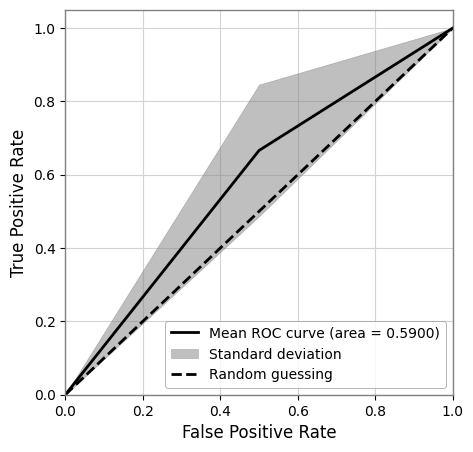

In [41]:
def plot_auc_average(fprs, tprs, aucs):
    max_length = max([len(fpr) for fpr in fprs])

    mean_fpr = np.linspace(0, 1, max_length)
    mean_tpr = np.zeros_like(mean_fpr)

    std_tpr = np.zeros_like(mean_fpr)

    for fpr, tpr in zip(fprs, tprs):
        mean_tpr += np.interp(mean_fpr, fpr, tpr)
        std_tpr += np.interp(mean_fpr, fpr, tpr) ** 2

    mean_tpr /= len(fprs)
    std_tpr = np.sqrt(std_tpr / len(fprs) - mean_tpr ** 2)

    mean_auc = np.mean(aucs)

    plt.figure(figsize=(5,5))
    plt.plot(mean_fpr, mean_tpr, color='black', lw=2, label='Mean ROC curve (area = {:.4f})'.format(mean_auc))
    plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color='gray', alpha=0.5, label="Standard deviation")

    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label="Random guessing")

    plt.xlim([0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.legend()


plot_auc_average(fprs, tprs, aucs)
# plt.savefig("auc_decision_tree.pdf", dpi=300)
